In [1]:
import numpy as np 
from scipy.special import factorial
import pylab as pl

### Define parameters

In [2]:
Nt = 800 # number of time points
k = 8
dtime = 0.001
buff_len = 10
delta = 27 # jump in the program memory from one instruction to the next
thr_double_peak = 0.05 # big T activaiton threshold (this is only a temporary solution)
ev_trh = 0.01 # evidence accumulation threshold

### Create supported dimension

In [3]:
class Support:
    
    def __init__(self, tstr_min=0.1, tstr_max=0.5, buff_len=10, k=8, dtime=0.001):
        self.tstr_min = tstr_min
        self.tstr_max = tstr_max
        self.buff_len = buff_len
        self.k = k
        self.dtime = dtime
        self.len_time = Nt*dtime
        
        self.N = self.buff_len+2*self.k
        self.Nt = int(self.len_time/self.dtime)

        #Create power-law growing Taustarlist and corresponding s
        a = (self.tstr_max/self.tstr_min)**(1./buff_len)-1
        pow_vec = np.arange(-self.k,buff_len + self.k) #-1
        self._Taustarlist = self.tstr_min * (1 + a)**pow_vec

        s = self.k/self._Taustarlist
        
        #Create DerivMatrix
        self._DerivMatrix = np.zeros((self.N,self.N))
        for i in range(1,self.N-1):
            self._DerivMatrix[i, i-1] = -(s[i+1]-s[i])/(s[i]-s[i-1])/(s[i+1] - s[i-1])
            self._DerivMatrix[i, i] = ((s[i+1]-s[i])/(s[i]- s[i-1])-(s[i]-s[i-1])/(s[i+1]-s[i]))/(s[i+1] - s[i-1])
            self._DerivMatrix[i, i+1] = (s[i]-s[i-1])/(s[i+1]-s[i])/(s[i+1] - s[i-1])

        self.t = np.zeros((self.N,self.Nt))
        self.T = np.zeros((self.N,self.Nt))
        self._s = s
        
    def update(self, time_index, f=np.zeros(Nt), alpha = 1):
        self.t[:,time_index] = self.t[:,time_index-1]+(alpha*(-self._s.T*self.t[:,time_index-1]+f[time_index])*self.dtime)
        # to avoid numerical errors if small t grows too high - t
        #div_on = 0
        if np.max(self.t[:,time_index]) > 0.01:
            self.t[:,time_index] = np.zeros(self.N)
        #    self.t[:,time_index] = self.t[:,time_index]/10
        #    div_on = 1
        t_diff = np.dot(np.linalg.matrix_power(self._DerivMatrix, self.k), self.t[:,time_index])
        L1 = (-1)**self.k*self._s**(self.k+1) # this can be taken out
        L2 = t_diff/factorial(self.k)
        self.T[:,time_index] = L1.T*L2.T
        #if div_on:
        #    self.T[:,time_index] = self.T[:,time_index]*10
        self.T[self.T[:,time_index]<0,time_index] = 0 # in case of numerical errors
        
    def jump(self, time_index, delta):
        R = np.diag(np.exp(delta*self._s))
        self.t[:,time_index] = np.dot(R,self.t[:,time_index]);

### Create an input node prototype

In [4]:
class input_node:
    
    def __init__(self, name):
        self.name = name
        self.support = Support()
        self.value = np.zeros(Nt)           

### Define input space

In [5]:
input_names = ['dog', 'cat', 'car', 'truck' ]

#cat = input_node(cat) # basic example

# for each input name create an instance of a class input_name with the name of the input
# all input instances are placed in a list called inputs
inputs = []
for name in input_names:
    inputs.append(input_node(name))

### Create an action node prototype

In [6]:
class input_node:
    
    def __init__(self, name):
        self.name = name
        self.support = Support()
        self.value = np.zeros(Nt) 

### Define action space

In [7]:
action_names = ['attend_to_change', 'diff', 'release', 'lick']

actions = []
for name in action_names:
    actions.append(input_node(name))

### Create program class

In [8]:
class program:
    
    def __init__(self):
        pass
    
    class dms:
        def __init__(self):
            
            self.alpha = -1 # default is to run the program
            
        def start(self, time_index, k=8):
            
            s = inputs[0].support._s
                        
            actions[action_names.index('attend_to_change')].support.t[:,time_index-1] = \
                dtime*np.exp(-inputs[0].support._Taustarlist[k+3]*s)
            
            #actions[action_names.index('attend_to_change_2')].support.t[:,time_index-1] = \
            #dtime*np.exp(-inputs[0].support._Taustarlist[k+2]*s)
            
            # normally the two peaks would end up too close to be detectable 
            # so when first peak is detected i decrease it by the impulse response peak amplitude to make second peak
            # detectable
            actions[action_names.index('attend_to_change')].support.t[:,time_index-1] = \
                actions[action_names.index('attend_to_change')].support.t[:,time_index-1] + \
                dtime*np.exp(-inputs[0].support._Taustarlist[k+4]*s)
                        
            actions[action_names.index('diff')].support.t[:,time_index-1] = \
                dtime*np.exp(-inputs[0].support._Taustarlist[k+5]*s)
            
            actions[action_names.index('release')].support.t[:,time_index-1] = \
                dtime*np.exp(-inputs[0].support._Taustarlist[k+6]*s)
            
            actions[action_names.index('lick')].support.t[:,time_index-1] = \
                dtime*np.exp(-inputs[0].support._Taustarlist[k+7]*s)
                
            actions[action_names.index('attend_to_change')].support.t[:,time_index-1] = \
                actions[action_names.index('attend_to_change')].support.t[:,time_index-1] + \
                dtime*np.exp(-inputs[0].support._Taustarlist[k+7]*s)
            
            actions[action_names.index('lick')].support.t[:,time_index-1] = \
                dtime*np.exp(-inputs[0].support._Taustarlist[k+8]*s)
                
        
        def set_alpha(self, alpha):
            self.alpha = alpha

### Describe specific actions

In [9]:
# complete the action 
def finish_action(name):
    s = inputs[0].support._s
    # if the amplitude was particularly high - meaning we have two peaks next tow each other
    if actions[action_names.index(name)].support.T[k,time_index] >= thr_double_peak:
        actions[action_names.index(name)].value[time_index+1] = 1.
        jump_program_memory(delta)
        # print the time stamp
        print('extend action')
        print time_index
        print name
    # when any element of small t becomes negative we zero those elemnts to avoid numerical error
    actions[action_names.index(name)].support.t[\
        actions[action_names.index(name)].support.t[:,time_index]<0,time_index] = 0
    # when any element of small t becomes negative we zero them all to avoid numerical error
    #if min(actions[action_names.index(name)].support.t[:,time_index])<0:
    #    actions[action_names.index(name)].support.t[:,time_index] = np.zeros(buff_len+2*k)
    
# scan through the input space and find a change
# for the moment this just tests if there is a non-zero input
def attend_to_change():
    # pause the program since no input
    dms.set_alpha(0)
    change = 0
    for name in input_names:
        if inputs[input_names.index(name)].value[time_index] > 0:
            # stop decay of the input neuron
            #inputs[input_names.index(name)].support.alpha = 0
            # move the program forward (technically backward)
            dms.set_alpha(-1)
            change = 1
            finish_action('attend_to_change')
    if not change: # if no change was found keep this node active
        actions[action_names.index('attend_to_change')].value[time_index+1] = 1.

# initialize memory scanner        
def scanner_init():
    scanner = Support()
    f_tmp = np.zeros(Nt)
    f_tmp[0] = 1
    scanner.update(0, f_tmp)
    return scanner

# scans memory along target input node at i-th time step in the past 
def scan(scanner, target, i):
    return sum(scanner.T[k:-k,i]*inputs[input_names.index(target)].support.T[k:-k,time_index])

# initialize evidence accumulator
def ev_acc_init():
    # evidence accumulators
    global evidence_l, evidence_r
    evidence_l = Support()
    evidence_r = Support()
    f_tmp = np.zeros(Nt)
    f_tmp[0] = 1
    evidence_l.update(0, f_tmp)
    evidence_r.update(0, f_tmp)
    return evidence_l, evidence_r

# accumulate evidence
def ev_acc(evidence_l, evidence_r, ev_acc_time, alpha_l=0, alpha_r=0):
    global ev_left, ev_right
    if alpha_l > 0:
        evidence_l.update(ev_acc_time, np.zeros(Nt), alpha_l*1000)
        if evidence_l.T[k+5, ev_acc_time] > ev_trh:
            ev_left = 1
    if alpha_r > 0:
        evidence_r.update(ev_acc_time, np.zeros(Nt), alpha_r*1000)
        if evidence_r.T[k+5, ev_acc_time] > ev_trh:
            ev_right = 1
        
# compare currently present stimulus with the next most recent stimulus            
def diff():
    dms.set_alpha(0)
    # initialize evidence accumulation
    evidence_l, evidence_r = ev_acc_init()
    # find stimulus that was just presented (looking into small t because it's no longer in f and big T did not 
    # peak at first taustar yet)
    max_val = 0
    for name in input_names:
        if sum(inputs[input_names.index(name)].support.t[:,time_index]) > max_val:
            target = name
            max_val = sum(inputs[input_names.index(name)].support.t[:,time_index])
    # now we need to scan the memory to find if previous stimulus was same or differet
    scanner = scanner_init()
    # scan trhough all taustars and send the output to evidence accumulator
    limit = int((scanner.tstr_max-scanner.tstr_min)/dtime)
    for i in range(limit):
        for name in input_names:
            ev = scan(scanner, name, i)
            if name == target:
                ev_acc(evidence_l, evidence_r, i+1, alpha_l = ev, alpha_r = 0)
            else:
                ev_acc(evidence_l, evidence_r, i+1, alpha_l = 0, alpha_r = ev)
        scanner.update(i+1)
    dms.set_alpha(-1)
    finish_action('diff')
    
def release():
    # if not enough evidence accumulated do not release
    if not ev_left:
        actions[action_names.index('release')].value[time_index] = 0
    # if enough evidence was accumulated attenuate attend_to_change
    else:
        actions[action_names.index('attend_to_change')].support.t[:,time_index] = np.zeros(buff_len+2*k)
    finish_action('release')
    
def left():
    if not ev_left:
        actions[action_names.index('left')].value[time_index] = 0
    finish_action('left')

def right():
    if not ev_right:
        actions[action_names.index('right')].value[time_index] = 0
    finish_action('right')

def lick():
    finish_action('lick')
    

### Update memory at every time step

In [10]:
def update_input_memory():
    for name in input_names:
        inputs[input_names.index(name)].support.update(time_index, inputs[input_names.index(name)].value)
    
def update_program_memory(alpha):    
    for name in action_names:
        actions[action_names.index(name)].support.update(time_index, np.zeros(Nt), alpha)
        
def jump_program_memory(delta):    
    for name in action_names:
        actions[action_names.index(name)].support.jump(time_index, delta*dtime)
        
def check_program_memory():
    dms.set_alpha(-1) # set back to -1
    for name in action_names:
        #if(actions[action_names.index(name)].support.T[k,time_index] >= thr): # if reached a peak
        if(actions[action_names.index(name)].support.T[k,time_index-1] > \
           actions[action_names.index(name)].support.T[k,time_index-2] and \
           actions[action_names.index(name)].support.T[k,time_index] < \
           actions[action_names.index(name)].support.T[k,time_index-1] and \
           actions[action_names.index(name)].support.T[k,time_index] >= 0.02): # if reached a peak
            print('peak')
            print time_index
            print name
            actions[action_names.index(name)].value[time_index] = 1. # made the corresponding action node active
        if actions[action_names.index(name)].value[time_index]: # it was either a peak or it was active from before
            eval(name+'()') # call the function that nodes is connected with 
                            # this could be solved in a more elegant way if action_names is a dictionary 
            #print('run action')
            #print time_index
            #print name

### Plot stuff

In [11]:
%matplotlib inline
#%matplotlib notebook
pl.ion()

def plot_inputs():
    for idx, name in enumerate(input_names):
        _ = pl.subplot(len(input_names), 1, idx+1)
        _ = pl.plot(inputs[input_names.index(name)].value, color='blue')
        
def plot_memory():
    k = inputs[0].support.k
    for idx, name in enumerate(input_names):
        _ = pl.subplot(len(input_names), 1, idx+1)
        #_ = pl.scatter(time_index, inputs[input_names.index(name)].support.T[k:-k,time_index], color='blue')
        _ = pl.plot(inputs[input_names.index(name)].support.T[k:-k,:].T, color='blue')
        
        
def plot_inputs_memory():
    fig = pl.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
    k = inputs[0].support.k
    for idx, name in enumerate(input_names):
        ax = pl.subplot(3, len(input_names), idx+1)
        ax.set_title(input_names[idx])
        ax.plot(inputs[input_names.index(name)].value, color='blue')
        ax = pl.subplot(3, len(input_names), idx+1+len(input_names))
        ax.plot(inputs[input_names.index(name)].support.t[k:-k,:].T, color='blue')
        ax = pl.subplot(3, len(input_names), idx+1+2*len(input_names))
        ax.plot(inputs[input_names.index(name)].support.T[k:-k,:].T, color='blue')
        
def plot_actions_memory():
    fig = pl.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
    k = inputs[0].support.k
    for idx, name in enumerate(action_names):
        ax = pl.subplot(3, len(action_names), idx+1)
        ax.set_title(action_names[idx])
        ax.plot(actions[action_names.index(name)].value, color='blue')
        ax = pl.subplot(3, len(action_names), idx+1+len(action_names))
        ax.plot(actions[action_names.index(name)].support.t[k:-k,:].T, color='blue')
        ax = pl.subplot(3, len(action_names), idx+1+2*len(action_names))
        ax.plot(actions[action_names.index(name)].support.T[k:-k,:].T, color='blue')

### Simulate an experiment

In [12]:
# initialize 

Ns = len(inputs) # size of the input space

dms = program.dms()

# initialize evidence accumulation
ev_left = 0
ev_right = 0

#fig1 = pl.figure()
#ax1 = fig1.add_subplot(111)
#ax1.hold(True)
#ax1.plot(x, y)

pl.tight_layout()

# zero all inputs
#for name in input_names:
#    inputs[input_names.index(name)].value = np.zeros(Nt)

for time_index in range(Nt-1):
    # add some inputs
    if(time_index == 100): # for test purposes this is hard coded
        dms.start(time_index) 
    if(time_index == 300):
        inputs[input_names.index('dog')].value[time_index] = 1
    if(time_index == 500):
        inputs[input_names.index('cat')].value[time_index] = 1
    if(time_index == 700):
        inputs[input_names.index('cat')].value[time_index] = 1
    # make memory decay for one time step
    update_input_memory()
    update_program_memory(dms.alpha)
    # check if program memory activates node - since it runs backwards
    check_program_memory()

peak
147
attend_to_change
extend action
300
attend_to_change
peak
514
diff
peak
553
release
peak
603
attend_to_change
peak
751
lick


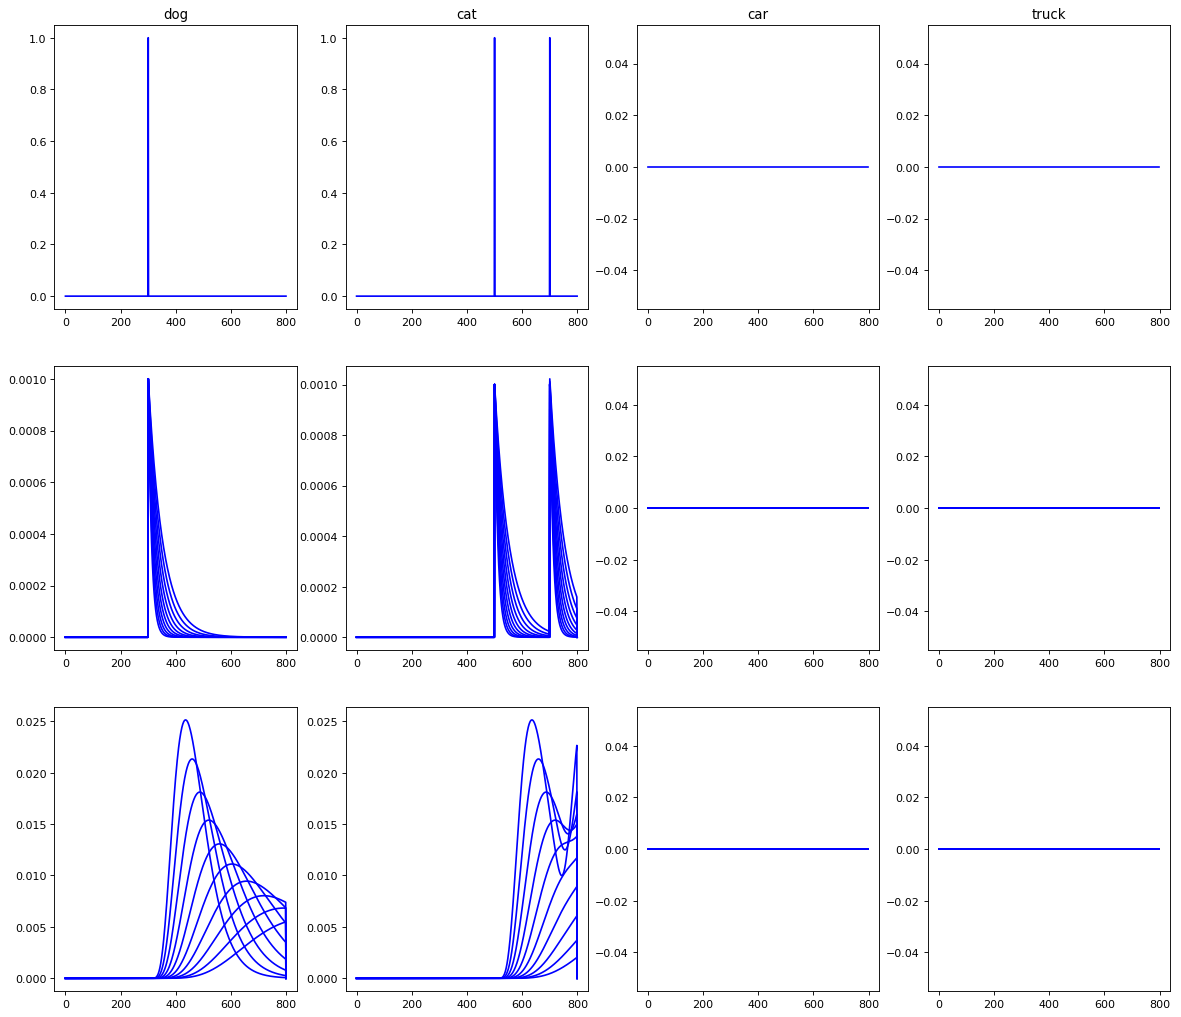

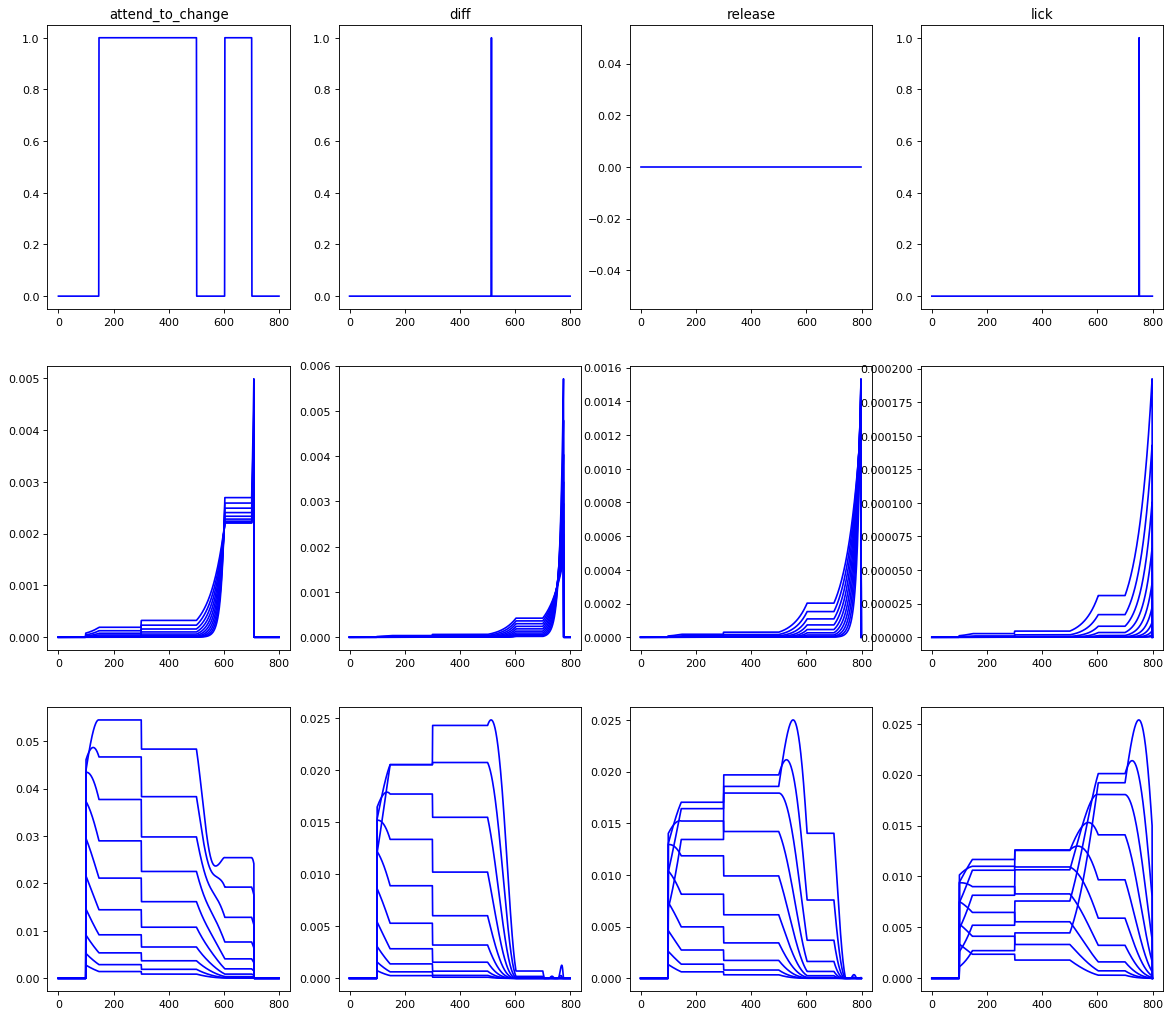

In [13]:
plot_inputs_memory()
plot_actions_memory()

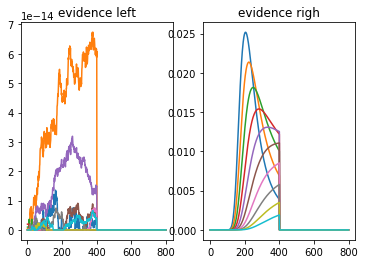

In [14]:
ax = pl.subplot(1,2,1)
_ = ax.plot(evidence_l.T[k:-k,:].T)
_ =ax.set_title('evidence left')
ax = pl.subplot(1,2,2)
_ = ax.plot(evidence_r.T[k:-k,:].T)
_ = ax.set_title('evidence righ')

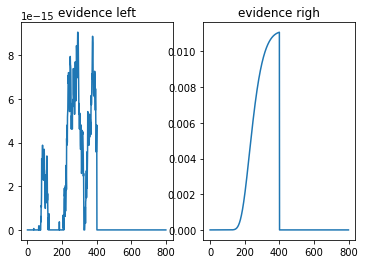

In [15]:
ax = pl.subplot(1,2,1)
_ = ax.plot(evidence_l.T[k+5,:].T)
_ =ax.set_title('evidence left')
ax = pl.subplot(1,2,2)
_ = ax.plot(evidence_r.T[k+5,:].T)
_ = ax.set_title('evidence righ')

28
[4.90297911e-21 2.04485751e-18 3.38789087e-16 2.57331262e-14
 1.01106381e-12 2.27491063e-11 3.19368421e-10 3.00728754e-09
 2.01895862e-08 1.01752173e-07 4.02116501e-07 1.29289035e-06
 3.48918147e-06 8.11547466e-06 1.66363680e-05 3.06340183e-05
 5.14927739e-05 8.00982822e-05 1.16647726e-04 1.60615586e-04
 2.10860757e-04 2.65823040e-04 3.23747798e-04 3.82889375e-04
 4.41664732e-04 4.98748505e-04]
4.902979109754001e-21
151
[1.94690464e-07 1.24236438e-06 5.22306660e-06 1.59037577e-05
 3.77560384e-05 7.39919357e-05 1.25090485e-04 1.88719610e-04
 2.60765026e-04 3.36642564e-04 4.12286424e-04 4.84633886e-04
 5.51704014e-04 6.12447406e-04 6.66513324e-04 7.14021064e-04
 7.55373435e-04 7.91120593e-04 8.21868533e-04 8.48222054e-04
 8.70752124e-04 8.89979478e-04 9.06368406e-04 9.20326599e-04
 9.32208312e-04 9.42319154e-04]
1.9469046415131822e-07
183
[0.00067184 0.0014451  0.00233594 0.00308029 0.00352364 0.00365949
 0.00356694 0.00334183 0.00306062 0.00277232 0.00250328 0.00226482
 0.00205968 0.

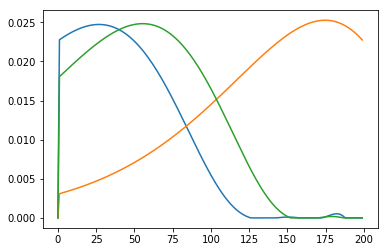

In [16]:
buff_len = 10
Nt = 200
test = Support(tstr_min=0.1, tstr_max=0.5, buff_len=buff_len, k=8, dtime=0.001)
test2 = Support(tstr_min=0.1, tstr_max=0.5, buff_len=buff_len, k=8, dtime=0.001)
test3 = Support(tstr_min=0.1, tstr_max=0.5, buff_len=buff_len, k=8, dtime=0.001)
s = test._s
test.t[:,0] = test.t[:,0] + dtime*np.exp(-test._Taustarlist[k+3]*s)
#test.t[:,0] = test.t[:,0] + dtime*np.exp(-test._Taustarlist[k+4]*s)
#test.t[:,0] = test.t[:,0] + dtime*np.exp(-test._Taustarlist[k+7]*s)
test2.t[:,0] = test2.t[:,0] + dtime*np.exp(-test2._Taustarlist[k+7]*s)
test3.t[:,0] = test3.t[:,0] + dtime*np.exp(-test3._Taustarlist[k+4]*s)
first_time = 1
for i in range(Nt-1):
    if(test.T[k,i-1] > test.T[k,i-2] and test.T[k,i] < test.T[k,i-1]):
        #test.t[:,i] = test.t[:,i] - dtime*np.exp(-(test._Taustarlist[k])*s)
        #if first_time:
        #    a = test3.t[:,i]
        #    first_time = 0
        #test.t[:,i] = test.t[:,i] - a # test3.t[:,i]
        #test.t[:,i] = test.t[:,i] - np.repeat(min(test.t[:,i]), buff_len+2*k)
        #test.t[test.t[:,i]<0,i] = 0
        #test.update(i+1, np.zeros(Nt), alpha = -1000)
        print i
        print test.t[:,i]
        print min(test.t[:,i])
    test.update(i+1, np.zeros(Nt), alpha = -1)
    test2.update(i+1, np.zeros(Nt), alpha = -1)
    test3.update(i+1, np.zeros(Nt), alpha = -1)
       
    #    print("test")
    #    test2.update(i+1, np.zeros(Nt), alpha = -27)
    #    print np.max(test.T[k,0:200].T)
        #_ = pl.plot(test.t[:,i])
        #_ = pl.plot(test.T[k,0:280].T)
        #_ = pl.plot(test2.T[k,0:280].T)
    
_ = pl.plot(test.T[k,0:Nt].T)
_ = pl.plot(test2.T[k,0:Nt].T)
_ = pl.plot(test3.T[k,0:Nt].T)

#print np.argmax(test.T[k,:].T)
#print np.argmax(test2.T[k,:].T)

#print test._Taustarlist

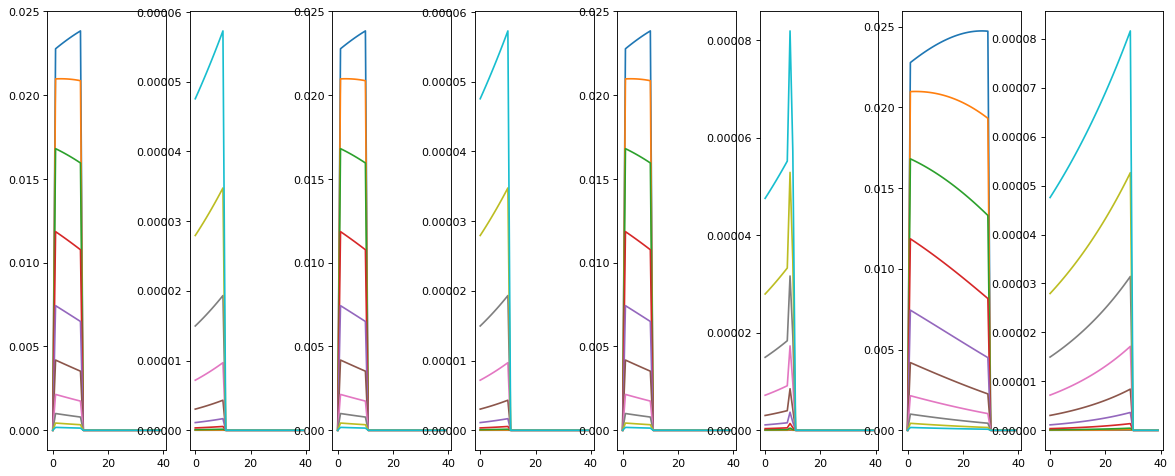

In [17]:
buff_len = 10
Nt = 40
test = Support(tstr_min=0.1, tstr_max=0.5, buff_len=buff_len, k=8, dtime=0.001)
test2 = Support(tstr_min=0.1, tstr_max=0.5, buff_len=buff_len, k=8, dtime=0.001)


s = test._s
test.t[:,0] = test.t[:,0] + dtime*np.exp(-test._Taustarlist[k+3]*s)
test2.t[:,0] = test2.t[:,0] + dtime*np.exp(-test._Taustarlist[k+3]*s)
for i in range(10):
    test.update(i+1, np.zeros(Nt), alpha = -1)
    test2.update(i+1, np.zeros(Nt), alpha = -1)

fig = pl.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')

ax = pl.subplot(2, 8, 1)
_ = ax.plot(test.T[k:-k,:].T)
ax = pl.subplot(2, 8, 2)
_ = ax.plot(test.t[k:-k,:].T)


ax = pl.subplot(2, 8, 3)
_ = ax.plot(test2.T[k:-k,:].T)
ax = pl.subplot(2, 8, 4)
_ = ax.plot(test2.t[k:-k,:].T)

#test.update(i+1, np.zeros(Nt), alpha = -20)
test.jump(i, 20*dtime)

ax = pl.subplot(2, 8, 5)
_ = ax.plot(test.T[k:-k,:].T)
ax = pl.subplot(2, 8, 6)
_ = ax.plot(test.t[k:-k,:].T)

for l in range(20):
    test2.update(i+l+1, np.zeros(Nt), alpha = -1)
    
ax = pl.subplot(2, 8, 7)
_ = ax.plot(test2.T[k:-k,:].T)
ax = pl.subplot(2, 8, 8)
_ = ax.plot(test2.t[k:-k,:].T)